NOTE: You must reinstall and/or update any special packages each time you run the colab notebook. Colab does not save your installaltions/updates and it will revert back to its basic state when the runtime shuts down. According to the link below, for every 12hrs or so, the Disk, RAM, VRAM, CPU cache, data, etc. that is on our alloted virtual machine will get erased.

For more information on Google colab's specs, please go to https://colab.research.google.com/drive/151805XTDg--dgHb3-AXJCpnWaqRhop_2

## Connect to your own Google Drive
In order to process your own videos, you can connect this colab notebook to your google drive or local drive. For the purposes of our project, we want to connect to our USC google drive. It can also work with our google share drive.

1. Run the cell below.
2. Go to the URL it displays in a separate browser.
3. Log into a Google account.
4. Accept the terms and conditions.
5. Copy and paste the authorization code in the input area of the cell below, then press Enter.
6. You should see that your Google drive was mounted.

In [0]:
# Reference Info: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import Packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from copy import deepcopy
# from fuzzywuzzy import fuzz, process

start_time = pd.datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


## Import the Dataset

In [0]:
# Read in the dataset into a pandas dataframe
filepath = '/content/gdrive/' # Path to the folder where the file is located
df = pd.read_csv(filepath + 'NY property data.csv')

# Create dataframes for the numerical and categorical data
numData = deepcopy(df)
catData = deepcopy(df)

allCols = df.columns.tolist()
catCols = ['RECORD','BBLE','B','BLOCK','LOT','EASEMENT','OWNER','BLDGCL','TAXCLASS','EXT','EXCD1','STADDR','ZIP','EXMPTCL','EXCD2','PERIOD','YEAR','VALTYPE']
numCols = list(set(allCols) - set(catCols))

numData = numData.drop(columns=catCols)
catData = catData.drop(columns=numCols)

## Data Imputation
Use the df2 dataframe for the data imputation. We'll keep the df dataframe in the original form.

In [0]:
# Copy the original dataframe (df) into df2 and just keep the data fields necessary for the data imputation
df2 = deepcopy(df)
dropCols_impute = ['RECORD','BBLE','PERIOD','YEAR','VALTYPE','LOT','EASEMENT','OWNER','EXT','EXCD1','EXMPTCL','EXCD2','AVLAND2','AVTOT2','EXLAND2','EXTOT2']
df2 = df2.drop(columns=dropCols_impute)

### Data Imputation for ZIP 
This data field is 97% populated with only 29,890 property records missing a value. 

Since this was such an important data field for the data imputation on the dataset as a whole, we worked to methodically and granularly fill the missing values based on location related data fields from the dataset. This meant using the B (borough), BLOCK, and STADDR (street address) data fields. 

To use the STADDR data field, we first copied the data field into a temporary column (e.g. STADDR_temp), then we modified the values such that the address number was removed and only the street name remained. When doing this, it was important to understand that addresses such as “1 STREET” or “2 STREET” were reduced to “STREET” and left a potential for causing inaccuracies. Nevertheless, we attempted to reduce the risk of inaccuracies when using this data field by grouping the data with the B and BLOCK data fields. Once the address numbers were removed from the temporary column, we then replaced the empty values with a dummy value (e.g. “empty address”) so that we could properly group and aggregate the data.

In [0]:
# Copy the STADDR data field into a new column and strip out the address numbers from the street address
df2['STADDR_temp'] = df2['STADDR']
df2['STADDR_temp'] = df2['STADDR_temp'].str.lstrip('1234567890. ') # remove the numbers in front of the street address
df2.head()

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,STADDR_temp
0,1,1,P7,4,500,1046,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0,0,LIBERTY ISLAND
1,1,1,Z9,4,27,0,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0,0,ELLIS ISLAND
2,1,2,Y7,4,709,564,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564,MARGINAL STREET
3,1,2,T2,4,793,551,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,PIER 6,10004.0,85,551,PIER 6
4,1,3,Q1,4,323,1260,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57,BATTERY PARK


In [0]:
df3 = deepcopy(df2) # copy df2 into another dataframe to alter the data fields; this is a throwaway dataframe
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan # This is a lambda functin to be used with the transform method on the pandas dataframe
df3['STADDR_temp2'] = df3['STADDR_temp'].fillna('empty') # fill the NaN values with a dummy value 

# Group by B, BLOCK, STADDR_temp2, then find the mode for the ZIP
df3['ZIP2'] = df3['ZIP'].fillna(df3.groupby(['B','BLOCK','STADDR_temp2'])['ZIP'].transform(f_zip)) # produced 12714 NaN

In [0]:
# Group by B, BLOCK, then find the mode for the ZIP
df3['ZIP3'] = df3['ZIP2'].fillna(df3.groupby(['B','BLOCK'])['ZIP2'].transform(f_zip)) # produced 2448 NaN after ZIP2 with STADDR_temp2 

In [0]:
# Group by B, STADDR_temp2, then find the mode for the ZIP
df3['ZIP4'] = df3['ZIP3'].fillna(df3.groupby(['B','STADDR_temp2'])['ZIP3'].transform(f_zip)) # produced 199 NaN after ZIP3 with BLOCK 

In [0]:
# Group by B, BLOCK, then find the mode for the ZIP
df3['ZIP5'] = df3['ZIP4'].fillna(df3.groupby(['B','BLOCK'])['ZIP4'].transform(f_zip)) # produced 96 NaN after ZIP4 with STADDR_temp2 

In [0]:
# Group by B, then find the mode for the ZIP
df3['ZIP6'] = df3['ZIP5'].fillna(df3.groupby(['B'])['ZIP5'].transform(f_zip)) # No more NaN values

In [0]:
df3.loc[df3['ZIP6'].isna()] # The results below show that there are no more NaN values for ZIP

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,STADDR_temp,STADDR_temp2,ZIP2,ZIP3,ZIP4,ZIP5,ZIP6


In [0]:
# Copy the fully imputated ZIP data field into df2
df2['ZIP'] = df3['ZIP6']

# Drop the STADDR_temp column
df2 = df2.drop(columns='STADDR_temp')
df2.head()

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH
0,1,1,P7,4,500,1046,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0,0
1,1,1,Z9,4,27,0,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0,0
2,1,2,Y7,4,709,564,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564
3,1,2,T2,4,793,551,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,PIER 6,10004.0,85,551
4,1,3,Q1,4,323,1260,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57


In [0]:
# df2.to_csv(filepath + 'ZIP_done.csv')

### Data Imputation for STORIES 
This data field is 94% populated and has 56,264‬ property records with missing values for the number of stories listed. 

In [0]:
df3 = deepcopy(df2) # copy df2 into another dataframe to alter the data fields; this is a throwaway dataframe
f_stories = lambda x: x.median() if x.count() >= 5 else np.nan # This is a lambda function to be used with the transform method on the pandas dataframe

# Group by ZIP, BLDGCL, BLOCK, then find the median for STORIES if there's at least 5 records in the grouping
df3['STORIES2'] = df3['STORIES'].fillna(df3.groupby(['ZIP','BLDGCL','BLOCK'])['STORIES'].transform(f_stories)) # produced 54233 NaN

In [0]:
# Group by ZIP, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping
df3['STORIES3'] = df3['STORIES2'].fillna(df3.groupby(['ZIP','BLDGCL'])['STORIES2'].transform(f_stories)) # produced 47390 NaN

In [0]:
# Group by ZIP, TAXCLASS, then find the median for STORIES if there's at least 5 records in the grouping
df3['STORIES4'] = df3['STORIES3'].fillna(df3.groupby(['ZIP','TAXCLASS'])['STORIES3'].transform(f_stories)) # produced 29402 NaN

In [0]:
# Group by B, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping
df3['STORIES5'] = df3['STORIES4'].fillna(df3.groupby(['B','BLDGCL'])['STORIES4'].transform(f_stories)) # produced 29371 NaN

#### Not Needed
The cells below were attempts to reduce the number of NaNs, but these methods were unsuccessful.

In [0]:
# Group by B, TAXCLASS, then find the median for STORIES is there's at least 5 records in the grouping
# df3['STORIES6'] = df3['STORIES5'].fillna(df3.groupby(['B','TAXCLASS'])['STORIES5'].transform(f_stories)) # produced 29371 NaN

In [0]:
# Group by 
# df3['STORIES7'] = df3['STORIES6'].fillna(df3.groupby(['BLDGCL'])['STORIES6'].transform(f_stories)) # produced 29371 NaN

In [0]:
# Group by 
# df3['STORIES8'] = df3['STORIES7'].fillna(df3.groupby(['TAXCLASS'])['STORIES7'].transform(f_stories)) # produced 29371 NaN

#### 2nd lambda function
Changed the lambda function to check for 3 or more values instead of 5 or more values

In [0]:
# This is a lambda function to be used with the transform method on the pandas dataframe
f_stories_alt = lambda x: x.median() if x.count() >= 3 else np.nan 

In [0]:
# Group by TAXCLASS, then find the median for STORIES is there's at least 3 records in the grouping
df3['STORIES6'] = df3['STORIES5'].fillna(df3.groupby(['TAXCLASS'])['STORIES5'].transform(f_stories_alt)) # produced 24736 NaN; BLDGCL didn't reduce the number

#### 3rd lambda function
Changed the lambda function to use the most common value (mode)

In [0]:
# This is a lambda function to be used with the transform method on the pandas dataframe
f_stories_alt2 = lambda x: x.mode()[0] if not x.mode().empty else np.nan # This is a lambda functin to be used with the transform method on the pandas dataframe

In [0]:
# Group by BLDGCL, then find the mode for STORIES
df3['STORIES7'] = df3['STORIES6'].fillna(df3.groupby(['BLDGCL'])['STORIES6'].transform(f_stories_alt2)) # produced 303 NaN

In [0]:
# Group by TAXCLASS, then find the mode for STORIES
df3['STORIES8'] = df3['STORIES7'].fillna(df3.groupby(['TAXCLASS'])['STORIES7'].transform(f_stories_alt2)) # no more NaN values

In [0]:
# A length of 0 shows there are no more NaN values
len(df3.loc[df3['STORIES8'].isna()])

0

In [0]:
# Copy the fully imputated STORIES data field into df2
df2['STORIES'] = df3['STORIES8']
df2.head()

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH
0,1,1,P7,4,500,1046,50.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0,0
1,1,1,Z9,4,27,0,50.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0,0
2,1,2,Y7,4,709,564,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564
3,1,2,T2,4,793,551,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,PIER 6,10004.0,85,551
4,1,3,Q1,4,323,1260,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57


In [0]:
# Output the df2 dataframe to a file
# df2.to_csv(filepath + 'ZIP_STORIES_done.csv')

### Data Imputation for FullVal

In [0]:
d=deepcopy(df2)
# Converting all '0' to NA values first
cols = ["FULLVAL","AVLAND","AVTOT"]
d[cols]=d[cols].replace({0:np.nan})

In [0]:
# Lambda function for filling the Full values of the Properties by the median of that group containing minimum of 5 elements
f_fullval = lambda x:x.median() if x.count()>=5 else np.nan 

Text(0, 0.5, 'Count')

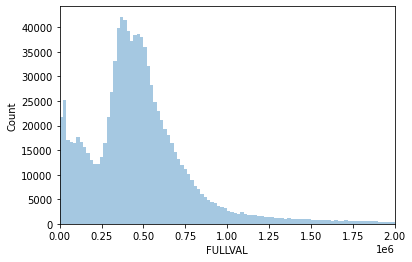

In [0]:
# Original distribution of FullVal
xhigh = 2000000
plt.xlim(0,xhigh)
temp = d[d['FULLVAL'] <= xhigh]
sns.distplot(temp['FULLVAL'],bins=100, kde=False)
plt.ylabel('Count')

In [0]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
d['FULLVAL2']=d['FULLVAL'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['FULLVAL'].transform(f_fullval))
#Filled 2489 NA values from 13007 NA values
d['FULLVAL2'].isnull().value_counts()

False    1060476
True       10518
Name: FULLVAL2, dtype: int64

In [0]:
# This group consists of two broader sub-groups namely ZIP and TAX CLASS, dropped Buidling Class.
d["FULLVAL3"]=d['FULLVAL2'].fillna(d.groupby(["ZIP","TAXCLASS"])['FULLVAL2'].transform(f_fullval))
# Filled 6061 NA values
d['FULLVAL3'].isnull().value_counts()

False    1066537
True        4457
Name: FULLVAL3, dtype: int64

In [0]:
# This group consists of grouping by ZIP only
d["FULLVAL4"]=d['FULLVAL3'].fillna(d.groupby(["ZIP"])['FULLVAL3'].transform(f_fullval)) 
# Filled 4456 NA values
d['FULLVAL4'].isnull().value_counts()

False    1070993
True           1
Name: FULLVAL4, dtype: int64

In [0]:
# Finally, grouping by TAXCLASS only
d["FULLVAL5"]=d['FULLVAL4'].fillna(d.groupby(["TAXCLASS"])['FULLVAL4'].transform(f_fullval)) 
# All NA values removed
d['FULLVAL5'].isnull().value_counts()

False    1070994
Name: FULLVAL5, dtype: int64

Text(0, 0.5, 'Count')

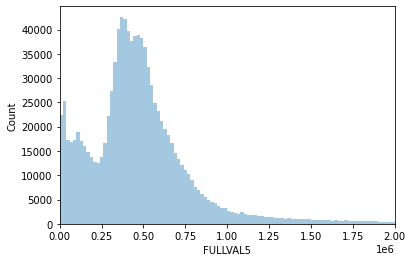

In [0]:
# Final distribution of FullVal after filling NA values
xhigh = 2000000
plt.xlim(0,xhigh)
temp = d[d['FULLVAL5'] <= xhigh]
sns.distplot(temp['FULLVAL5'],bins=100, kde=False)
plt.ylabel('Count')

### Data Imputation for AVLAND

Text(0, 0.5, 'Count')

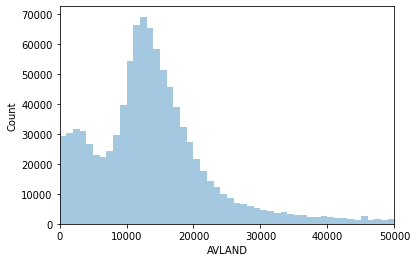

In [0]:
# Original Distribution of AVLAND
xhigh = 50000
plt.xlim(0,xhigh)
temp = d[d['AVLAND'] <= xhigh]
sns.distplot(temp['AVLAND'],bins=50, kde=False)
plt.ylabel('Count')

In [0]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
d['AVLAND2']=d['AVLAND'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVLAND'].transform(f_fullval))
#Filled 2489 NA values from 13007 NA values
d['AVLAND2'].isnull().value_counts()

False    1060476
True       10518
Name: AVLAND2, dtype: int64

In [0]:
# Similar to the Full Value, grouping by ZIP and Tax class first
d['AVLAND3']=d['AVLAND2'].fillna(d.groupby(["ZIP","TAXCLASS"])['AVLAND2'].transform(f_fullval))
# Grouping by ZIP
d['AVLAND4']=d['AVLAND3'].fillna(d.groupby(["ZIP"])['AVLAND3'].transform(f_fullval))
# Grouping by Taxclass only
d['AVLAND5']=d['AVLAND4'].fillna(d.groupby(["TAXCLASS"])['AVLAND4'].transform(f_fullval))
d['AVLAND5'].isnull().value_counts()
# All NA values filled

False    1070994
Name: AVLAND5, dtype: int64

Text(0, 0.5, 'Count')

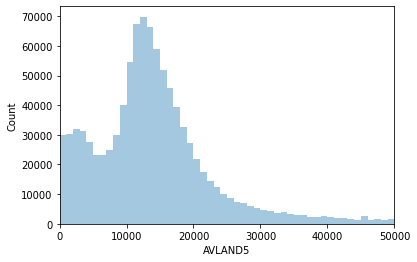

In [0]:
# Final distribution of FullVal after filling NA values
xhigh = 50000
plt.xlim(0,xhigh)
temp = d[d['AVLAND5'] <= xhigh]
sns.distplot(temp['AVLAND5'],bins=50, kde=False)
plt.ylabel('Count')

### Data Imputation for AVTOT

Text(0, 0.5, 'Count')

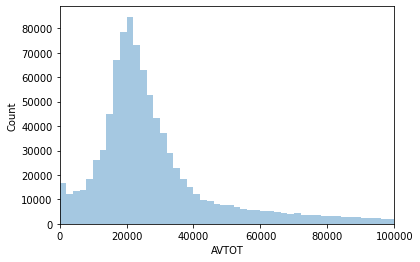

In [0]:
# Original distribution of AVTOT
xhigh = 100000
plt.xlim(0,xhigh)
temp = d[d['AVTOT'] <= xhigh]
sns.distplot(temp['AVTOT'],bins=50, kde=False)
plt.ylabel('Count')

In [0]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
d['AVTOT2']=d['AVTOT'].fillna(d.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVTOT'].transform(f_fullval))
# Filled 2488 NA values from 13007 NA values

In [0]:
# Similar to the Full Value, grouping by ZIP and Tax class first
d['AVTOT3']=d['AVTOT2'].fillna(d.groupby(["ZIP","TAXCLASS"])['AVTOT2'].transform(f_fullval))
# Grouping by ZIP
d['AVTOT4']=d['AVTOT3'].fillna(d.groupby(["ZIP"])['AVTOT3'].transform(f_fullval))
# Grouping by Taxclass only
d['AVTOT5']=d['AVTOT4'].fillna(d.groupby(["TAXCLASS"])['AVTOT4'].transform(f_fullval))
# All NA values filled

Text(0, 0.5, 'Count')

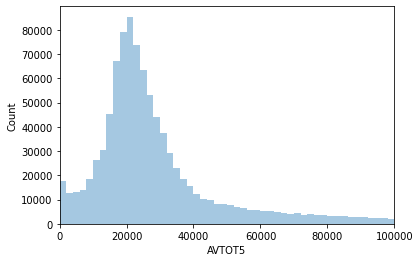

In [0]:
xhigh = 100000
plt.xlim(0,xhigh)
temp = d[d['AVTOT5'] <= xhigh]
sns.distplot(temp['AVTOT5'],bins=50, kde=False)
plt.ylabel('Count')

In [0]:
# Dropping Unfilled Columns
d1=d.drop(["FULLVAL","FULLVAL2","FULLVAL3","FULLVAL4","AVLAND","AVLAND2","AVLAND3","AVLAND4","AVTOT","AVTOT2","AVTOT3",
        "AVTOT4"],axis=1)

In [0]:
# Renaming the columns back to original names
d1=d1.rename(columns={"FULLVAL5":"FULLVAL","AVLAND5":"AVLAND","AVTOT5":"AVTOT"})

### Data Imputation for LTFRONT


In [0]:
df2 = deepcopy(d1)
#check how many null value and 0 in LTFRONT
attribute = 'LTFRONT'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

Null Value Number Counts
0
0 Value Counts
169108


In [0]:
#generate a dataset non0 in which all LTFRONT has values
non0 = df2[df2[attribute] != 0].copy()  
#print('0 Value Number Counts')

In [0]:
#define a function f_mode to get the mode (list unique values and count numbers of each value, then take the frist unique value)
def f_mode (x):
    return x.value_counts().index[0]

In [0]:
#generate dataset non0_LTFR which includes LTFRONT, ZIP and BLDGCL
non0_LTFR = non0[[attribute, 'ZIP','BLDGCL']].copy()
#group by ZIP and BLDGL and get the mode of LTFRONT for each group
temp = non0_LTFR.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

LTFRONT
ZIP     BLDGCL         
10001.0 A4           19
        A5           18
        A9           15
        B9           15
        C0           18
...                 ...
11697.0 V0          200
        V1          366
        Z9         5380
33803.0 G7           20
        V0           40

[15255 rows x 1 columns]

In [0]:
type(temp)

pandas.core.frame.DataFrame

In [0]:
#locate the record with same ZIP and BLDGCL and replace 0 with the mode
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue


In [0]:
df2.head(10)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0,0,21400000.0,4225500.0,9630000.0
1,1,1,Z9,4,27,0,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0,0,193800000.0,14310000.0,87210000.0
2,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564,104686000.0,39008700.0,47108700.0
3,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85,551,39200000.0,15255000.0,17640000.0
4,1,3,Q1,4,323,1260,1.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57,272300000.0,121050000.0,122535000.0
5,1,3,Q1,4,496,76,50.0,4770000.0,4770000.0,PETER MINUIT PLAZA,10004.0,0,0,10600000.0,4770000.0,4770000.0
6,1,3,Q1,4,180,370,1.0,3820499.0,3820499.0,PETER MINUIT PLAZA,10004.0,16,19,8489997.0,3820499.0,3820499.0
7,1,3,Z9,4,362,177,3.0,11070000.0,12645000.0,1 SOUTH STREET,10004.0,37,227,28100000.0,11070000.0,12645000.0
8,1,4,R5,4,422,0,50.0,0.0,0.0,1 WATER STREET,10004.0,0,0,3944762.0,636093.0,1775143.0
9,1,4,R5,4,422,0,50.0,0.0,0.0,1 WATER STREET,10004.0,0,0,5700930.0,919276.0,2565419.0


In [0]:
#check how many 0 still left in LTFRONT
print(len(df2.loc[df2[attribute] == 0]))

16122


In [0]:
#group by ZIP and relace 0 by mode in the same ZIP group
non0_LTFR = non0[[attribute, 'ZIP']].copy()
temp = non0_LTFR.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

,LTFRONT
ZIP,
10001.0,25
10002.0,25
10003.0,244
10004.0,422
10005.0,197
...,...
11694.0,40
11695.0,540
11696.0,75


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

In [0]:
#check how many 0 left in LTFRONT
print(len(df2.loc[df2[attribute] == 0]))

0


### Data Imputation for LTDEPTH


In [0]:
#the method to fill up LTDEPTH is same as LTFRONT
attribute = 'LTDEPTH'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

Null Value Number Counts
0
0 Value Counts
170128


In [0]:
non0 = df2[df2[attribute] != 0].copy()  
print('0 Value Number Counts')

0 Value Number Counts


In [0]:
non0_LTDP = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_LTDP.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

LTDEPTH
ZIP     BLDGCL         
10001.0 A4           98
        A5           98
        A9           98
        B9           98
        C0           98
...                 ...
11697.0 V0          265
        V1          221
        Z9         2010
33803.0 G7          118
        V0          118

[15254 rows x 1 columns]

In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

In [0]:
df2.head(10)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,0,0,21400000.0,4225500.0,9630000.0
1,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,0,0,193800000.0,14310000.0,87210000.0
2,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564,104686000.0,39008700.0,47108700.0
3,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85,551,39200000.0,15255000.0,17640000.0
4,1,3,Q1,4,323,1260,1.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57,272300000.0,121050000.0,122535000.0
5,1,3,Q1,4,496,76,50.0,4770000.0,4770000.0,PETER MINUIT PLAZA,10004.0,0,0,10600000.0,4770000.0,4770000.0
6,1,3,Q1,4,180,370,1.0,3820499.0,3820499.0,PETER MINUIT PLAZA,10004.0,16,19,8489997.0,3820499.0,3820499.0
7,1,3,Z9,4,362,177,3.0,11070000.0,12645000.0,1 SOUTH STREET,10004.0,37,227,28100000.0,11070000.0,12645000.0
8,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,0,0,3944762.0,636093.0,1775143.0
9,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,0,0,5700930.0,919276.0,2565419.0


In [0]:
print(len(df2.loc[df2[attribute] == 0]))

17858


In [0]:
non0_LTDP = non0[[attribute, 'ZIP']].copy()
temp = non0_LTDP.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

,LTDEPTH
ZIP,
10001.0,98
10002.0,100
10003.0,425
10004.0,355
10005.0,171
...,...
11694.0,100
11695.0,518
11696.0,143


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

In [0]:
print(len(df2.loc[df2[attribute] == 0]))

0


### Data Imputation for BLDFRONT


In [0]:
#the method to fill up BLDFRONT is same as LTFRONT
attribute = 'BLDFRONT'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

Null Value Number Counts
0
0 Value Counts
228815


In [0]:
non0 = df2[df2[attribute] != 0].copy()  
print('0 Value Number Counts')

0 Value Number Counts


In [0]:
non0_BDFR = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_BDFR.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

BLDFRONT
ZIP     BLDGCL          
10001.0 A4            19
        A5            18
        A9            15
        B9            15
        C0            18
...                  ...
11697.0 A8            30
        D1            72
        G9             8
        P6           100
        Z9            20

[13320 rows x 1 columns]

In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

In [0]:
df2.head(10)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,34,0,21400000.0,4225500.0,9630000.0
1,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,37,0,193800000.0,14310000.0,87210000.0
2,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564,104686000.0,39008700.0,47108700.0
3,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85,551,39200000.0,15255000.0,17640000.0
4,1,3,Q1,4,323,1260,1.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57,272300000.0,121050000.0,122535000.0
5,1,3,Q1,4,496,76,50.0,4770000.0,4770000.0,PETER MINUIT PLAZA,10004.0,89,0,10600000.0,4770000.0,4770000.0
6,1,3,Q1,4,180,370,1.0,3820499.0,3820499.0,PETER MINUIT PLAZA,10004.0,16,19,8489997.0,3820499.0,3820499.0
7,1,3,Z9,4,362,177,3.0,11070000.0,12645000.0,1 SOUTH STREET,10004.0,37,227,28100000.0,11070000.0,12645000.0
8,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,382,0,3944762.0,636093.0,1775143.0
9,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,382,0,5700930.0,919276.0,2565419.0


In [0]:
print(len(df2.loc[df2[attribute] == 0]))

74917


In [0]:
non0_BDFR = non0[[attribute, 'ZIP']].copy()
temp = non0_BDFR.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

,BLDFRONT
ZIP,
10001.0,25
10002.0,25
10003.0,25
10004.0,132
10005.0,151
...,...
11692.0,20
11693.0,20
11694.0,25


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

In [0]:
print(len(df2.loc[df2[attribute] == 0]))

192


In [0]:
non0_BDFR = non0[[attribute, 'B']].copy()
temp = non0_BDFR.groupby(['B',])[[attribute]].agg(f_mode).copy()
temp

,BLDFRONT
B,
1,25
2,20
3,20
4,20
5,25


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_B = df2.loc[i,'B']
        df2.loc[i, attribute] = temp.loc[temp_B,attribute]
    except:
        continue

In [0]:
print(len(df2.loc[df2[attribute] == 0]))

0


### Data Imputation for BLDDEPTH



In [0]:
#the method to fill up BLDDEPTH is same as LTFRONT
attribute = 'BLDDEPTH'
print('Null Value Number Counts')
print(df2[attribute].isnull().sum())

print('0 Value Counts')
print(len(df2.loc[df2[attribute] == 0]))

Null Value Number Counts
0
0 Value Counts
228853


In [0]:
non0 = df2[df2[attribute] != 0].copy()  
print('0 Value Number Counts')

0 Value Number Counts


In [0]:
non0_BDDP = non0[[attribute, 'ZIP','BLDGCL']].copy()
temp = non0_BDDP.groupby(['ZIP','BLDGCL'])[[attribute]].agg(f_mode).copy()
temp

BLDDEPTH
ZIP     BLDGCL          
10001.0 A4            36
        A5            46
        A9            50
        B9            33
        C0            44
...                  ...
11697.0 A8            40
        D1            85
        G9            18
        P6           120
        Z9           100

[13311 rows x 1 columns]

In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        temp_BLDGCL = df2.loc[i,'BLDGCL']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,].loc[temp_BLDGCL,attribute]
    except:
        continue

In [0]:
df2.head(10)

,B,BLOCK,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,STORIES,EXLAND,EXTOT,STADDR,ZIP,BLDFRONT,BLDDEPTH,FULLVAL,AVLAND,AVTOT
0,1,1,P7,4,500,1046,50.0,4225500.0,9630000.0,1 LIBERTY ISLAND,10004.0,34,63,21400000.0,4225500.0,9630000.0
1,1,1,Z9,4,27,177,50.0,14310000.0,87210000.0,1 ELLIS ISLAND,10004.0,37,227,193800000.0,14310000.0,87210000.0
2,1,2,Y7,4,709,564,3.0,39008700.0,47108700.0,MARGINAL STREET,10004.0,709,564,104686000.0,39008700.0,47108700.0
3,1,2,T2,4,793,551,2.0,15255000.0,17640000.0,PIER 6,10004.0,85,551,39200000.0,15255000.0,17640000.0
4,1,3,Q1,4,323,1260,1.0,121050000.0,122535000.0,BATTERY PARK,10004.0,89,57,272300000.0,121050000.0,122535000.0
5,1,3,Q1,4,496,76,50.0,4770000.0,4770000.0,PETER MINUIT PLAZA,10004.0,89,19,10600000.0,4770000.0,4770000.0
6,1,3,Q1,4,180,370,1.0,3820499.0,3820499.0,PETER MINUIT PLAZA,10004.0,16,19,8489997.0,3820499.0,3820499.0
7,1,3,Z9,4,362,177,3.0,11070000.0,12645000.0,1 SOUTH STREET,10004.0,37,227,28100000.0,11070000.0,12645000.0
8,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,382,318,3944762.0,636093.0,1775143.0
9,1,4,R5,4,422,355,50.0,0.0,0.0,1 WATER STREET,10004.0,382,318,5700930.0,919276.0,2565419.0


In [0]:
print(len(df2.loc[df2[attribute] == 0]))

74920


In [0]:
non0_BDDP = non0[[attribute, 'ZIP']].copy()
temp = non0_BDDP.groupby(['ZIP',])[[attribute]].agg(f_mode).copy()
temp

,BLDDEPTH
ZIP,
10001.0,98
10002.0,88
10003.0,100
10004.0,115
10005.0,149
...,...
11692.0,45
11693.0,50
11694.0,40


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_ZIP = df2.loc[i,'ZIP']
        df2.loc[i, attribute] = temp.loc[temp_ZIP,attribute]
    except:
        continue

In [0]:
print(len(df2.loc[df2[attribute] == 0]))

192


In [0]:
non0_BDDP = non0[[attribute, 'B']].copy()
temp = non0_BDDP.groupby(['B',])[[attribute]].agg(f_mode).copy()
temp

,BLDDEPTH
B,
1,100
2,50
3,50
4,36
5,40


In [0]:
for i in df2[df2[attribute] == 0].index:
    try:
        temp_B = df2.loc[i,'B']
        df2.loc[i, attribute] = temp.loc[temp_B,attribute]
    except:
        continue

In [0]:
print(len(df2.loc[df2[attribute] == 0]))

0


## Verify Data Imputation
Verify all appropriate data fields have been filled and then output to a CSV file.

In [0]:
# Verify all the data fields have been filled in df2
fields = df2.columns # column headers in df2

for item in fields:
  print(item, '; NaN: ', len(df2.loc[df2[item].isna()]), "; 0's: ",len(df2.loc[df2[item]==0]))

B ; NaN:  0 ; 0's:  0
BLOCK ; NaN:  0 ; 0's:  0
BLDGCL ; NaN:  0 ; 0's:  0
TAXCLASS ; NaN:  0 ; 0's:  0
LTFRONT ; NaN:  0 ; 0's:  0
LTDEPTH ; NaN:  0 ; 0's:  0
STORIES ; NaN:  0 ; 0's:  0
EXLAND ; NaN:  0 ; 0's:  491699
EXTOT ; NaN:  0 ; 0's:  432572
STADDR ; NaN:  676 ; 0's:  0
ZIP ; NaN:  0 ; 0's:  0
BLDFRONT ; NaN:  0 ; 0's:  0
BLDDEPTH ; NaN:  0 ; 0's:  0
FULLVAL ; NaN:  0 ; 0's:  0
AVLAND ; NaN:  0 ; 0's:  0
AVTOT ; NaN:  0 ; 0's:  0


In [0]:
# Save df2 to a csv file
# df2.to_csv(filepath + 'all_done.csv')

In [0]:
# Copy all the fully imputed fields into the full dataset as we had dropped the columns earlier from df2 and output to a csv file
df_full = deepcopy(df)

for item in fields:
  df_full[item] = df2[item]

for item in fields:
  print(item, '; NaN:', len(df_full.loc[df_full[item].isna()]), "; 0's:",len(df_full.loc[df_full[item]==0]))

B ; NaN: 0 ; 0's: 0
BLOCK ; NaN: 0 ; 0's: 0
BLDGCL ; NaN: 0 ; 0's: 0
TAXCLASS ; NaN: 0 ; 0's: 0
LTFRONT ; NaN: 0 ; 0's: 0
LTDEPTH ; NaN: 0 ; 0's: 0
STORIES ; NaN: 0 ; 0's: 0
EXLAND ; NaN: 0 ; 0's: 491699
EXTOT ; NaN: 0 ; 0's: 432572
STADDR ; NaN: 676 ; 0's: 0
ZIP ; NaN: 0 ; 0's: 0
BLDFRONT ; NaN: 0 ; 0's: 0
BLDDEPTH ; NaN: 0 ; 0's: 0
FULLVAL ; NaN: 0 ; 0's: 0
AVLAND ; NaN: 0 ; 0's: 0
AVTOT ; NaN: 0 ; 0's: 0


In [0]:
# Save df_full to a csv file
# df_full.to_csv(filepath + 'NY property data COMPLETE.csv')

In [0]:
fields_all = df.columns
for item in fields_all:
  print(item, "; NaN's =", len(df_full.loc[df_full[item].isna()]), "; Zero's =",len(df_full.loc[df_full[item]==0]))

RECORD ; NaN's = 0 ; Zero's = 0
BBLE ; NaN's = 0 ; Zero's = 0
B ; NaN's = 0 ; Zero's = 0
BLOCK ; NaN's = 0 ; Zero's = 0
LOT ; NaN's = 0 ; Zero's = 0
EASEMENT ; NaN's = 1066358 ; Zero's = 0
OWNER ; NaN's = 31745 ; Zero's = 0
BLDGCL ; NaN's = 0 ; Zero's = 0
TAXCLASS ; NaN's = 0 ; Zero's = 0
LTFRONT ; NaN's = 0 ; Zero's = 0
LTDEPTH ; NaN's = 0 ; Zero's = 0
EXT ; NaN's = 716689 ; Zero's = 0
STORIES ; NaN's = 0 ; Zero's = 0
FULLVAL ; NaN's = 0 ; Zero's = 0
AVLAND ; NaN's = 0 ; Zero's = 0
AVTOT ; NaN's = 0 ; Zero's = 0
EXLAND ; NaN's = 0 ; Zero's = 491699
EXTOT ; NaN's = 0 ; Zero's = 432572
EXCD1 ; NaN's = 432506 ; Zero's = 0
STADDR ; NaN's = 676 ; Zero's = 0
ZIP ; NaN's = 0 ; Zero's = 0
EXMPTCL ; NaN's = 1055415 ; Zero's = 0
BLDFRONT ; NaN's = 0 ; Zero's = 0
BLDDEPTH ; NaN's = 0 ; Zero's = 0
AVLAND2 ; NaN's = 788268 ; Zero's = 0
AVTOT2 ; NaN's = 788262 ; Zero's = 0
EXLAND2 ; NaN's = 983545 ; Zero's = 0
EXTOT2 ; NaN's = 940166 ; Zero's = 0
EXCD2 ; NaN's = 978046 ; Zero's = 0
PERIOD ; NaN's =

# Variable Creation

#### Area Variables

In [0]:
d = deepcopy(df_full)
d["LOTAREA"]=d.LTFRONT*d.LTDEPTH
d["BLDAREA"]=d.BLDFRONT*d.BLDDEPTH
d["BLDVOL"]=d.BLDAREA*d.STORIES

### Data fields divided by Area Variables to create new normalised variables 

In [0]:
d["FULLVAL/LOTAREA"]=d.FULLVAL/d.LOTAREA
d["FULLVAL/BLDAREA"]=d.FULLVAL/d.BLDAREA
d["FULLVAL/BLDVOL"]=d.FULLVAL/d.BLDVOL
d["AVLAND/LOTAREA"]=d.AVLAND/d.LOTAREA
d["AVLAND/BLDAREA"]=d.AVLAND/d.BLDAREA
d["AVLAND/BLDVOL"]=d.AVLAND/d.BLDVOL
d["AVTOT/LOTAREA"]=d.AVTOT/d.LOTAREA
d["AVTOT/BLDAREA"]=d.AVTOT/d.BLDAREA
d["AVTOT/BLDVOL"]=d.AVTOT/d.BLDVOL

In [0]:
d.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,LOTAREA,BLDAREA,BLDVOL,FULLVAL/LOTAREA,FULLVAL/BLDAREA,FULLVAL/BLDVOL,AVLAND/LOTAREA,AVLAND/BLDAREA,AVLAND/BLDVOL,AVTOT/LOTAREA,AVTOT/BLDAREA,AVTOT/BLDVOL
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,50.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,34,63,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000,2142,107100.0,40.917782,9990.662932,199.813259,8.079350,1972.689076,39.453782,18.413002,4495.798319,89.915966
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,177,NaN,50.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,37,227,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,4779,8399,419950.0,40552.416824,23074.175497,461.483510,2994.350282,1703.774259,34.075485,18248.587571,10383.378974,207.667579
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,399876,399876,1199628.0,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,436943,46835,93670.0,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,406980,5073,5073.0,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


In [0]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 44 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   RECORD           1070994 non-null  int64  
 1   BBLE             1070994 non-null  object 
 2   B                1070994 non-null  int64  
 3   BLOCK            1070994 non-null  int64  
 4   LOT              1070994 non-null  int64  
 5   EASEMENT         4636 non-null     object 
 6   OWNER            1039249 non-null  object 
 7   BLDGCL           1070994 non-null  object 
 8   TAXCLASS         1070994 non-null  object 
 9   LTFRONT          1070994 non-null  int64  
 10  LTDEPTH          1070994 non-null  int64  
 11  EXT              354305 non-null   object 
 12  STORIES          1070994 non-null  float64
 13  FULLVAL          1070994 non-null  float64
 14  AVLAND           1070994 non-null  float64
 15  AVTOT            1070994 non-null  float64
 16  EXLAND           1

In [0]:
# Creating ZIP3 by taking first 3 digits of ZIP code
d1=d.ZIP.astype(str)
d["ZIP3"]=[x[0:3] for x in d1]

In [0]:
# lambda function to create variables by dividing the 9 normalised variables with the grouped averages 
f= lambda x:x/x.mean()

In [0]:
# Fullval & Lotarea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["FULLVAL/LOTAREA_ZIP",
"FULLVAL/LOTAREA_ZIP3",
"FULLVAL/LOTAREA_TAXCLASS",
"FULLVAL/LOTAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["FULLVAL/LOTAREA"].apply(f)

In [0]:
# Fullval & Bldarea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["FULLVAL/BLDAREA_ZIP",
"FULLVAL/BLDAREA_ZIP3",
"FULLVAL/BLDAREA_TAXCLASS",
"FULLVAL/BLDAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["FULLVAL/BLDAREA"].apply(f)

In [0]:
# Fullval & Bldvol
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["FULLVAL/BLDVOL_ZIP",
"FULLVAL/BLDVOL_ZIP3",
"FULLVAL/BLDVOL_TAXCLASS",
"FULLVAL/BLDVOL_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["FULLVAL/BLDVOL"].apply(f)

In [0]:
# Avland & Lotarea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVLAND/LOTAREA_ZIP",
"AVLAND/LOTAREA_ZIP3",
"AVLAND/LOTAREA_TAXCLASS",
"AVLAND/LOTAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVLAND/LOTAREA"].apply(f)

In [0]:
# Avland & Bldarea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVLAND/BLDAREA_ZIP",
"AVLAND/BLDAREA_ZIP3",
"AVLAND/BLDAREA_TAXCLASS",
"AVLAND/BLDAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVLAND/BLDAREA"].apply(f)

In [0]:
# Avland & Bldvol
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVLAND/BLDVOL_ZIP",
"AVLAND/BLDVOL_ZIP3",
"AVLAND/BLDVOL_TAXCLASS",
"AVLAND/BLDVOL_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVLAND/BLDVOL"].apply(f)

In [0]:
# Avtot & LotArea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVTOT/LOTAREA_ZIP",
"AVTOT/LOTAREA_ZIP3",
"AVTOT/LOTAREA_TAXCLASS",
"AVTOT/LOTAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVTOT/LOTAREA"].apply(f)

In [0]:
# Avtot & BldArea
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVTOT/BLDAREA_ZIP",
"AVTOT/BLDAREA_ZIP3",
"AVTOT/BLDAREA_TAXCLASS",
"AVTOT/BLDAREA_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVTOT/BLDAREA"].apply(f)

In [0]:
#  Avtot & BldVol
cols = ["ZIP","ZIP3","TAXCLASS","B"]
var = ["AVTOT/BLDVOL_ZIP",
"AVTOT/BLDVOL_ZIP3",
"AVTOT/BLDVOL_TAXCLASS",
"AVTOT/BLDVOL_B"]
for i,j in zip(cols,var):
    d[j]=d.groupby([i])["AVTOT/BLDVOL"].apply(f)

In [0]:
# 9 Variables by dividing with the mean of the whole column and not the group
a=d["FULLVAL/LOTAREA"].mean()
b=d["FULLVAL/BLDAREA"].mean()
c=d["FULLVAL/BLDVOL"].mean()
k=d["AVLAND/LOTAREA"].mean()
e=d["AVLAND/BLDAREA"].mean()
f=d["AVLAND/BLDVOL"].mean()
g=d["AVTOT/LOTAREA"].mean()
h=d["AVTOT/BLDAREA"].mean()
i=d["AVTOT/BLDVOL"].mean()
d["FULLVAL/LOTAREA_FULL"]=d["FULLVAL/LOTAREA"]/a
d["FULLVAL/BLDAREA_FULL"]=d["FULLVAL/BLDAREA"]/b
d["FULLVAL/BLDVOL_FULL"]=d["FULLVAL/BLDVOL"]/c
d["AVLAND/LOTAREA_FULL"]=d["AVLAND/LOTAREA"]/k
d["AVLAND/BLDAREA_FULL"]=d["AVLAND/BLDAREA"]/e
d["AVLAND/BLDVOL_FULL"]=d["AVLAND/BLDVOL"]/f
d["AVTOT/LOTAREA_FULL"]=d["AVTOT/LOTAREA"]/g
d["AVTOT/BLDAREA_FULL"]=d["AVTOT/BLDAREA"]/h
d["AVTOT/BLDVOL_FULL"]=d["AVTOT/BLDVOL"]/i

In [0]:
d.shape

(1070994, 90)

In [0]:
df_45_vars = d.iloc[:,45:90].copy()

# Dimensionality Reduction & Outlier Detection

### 1. Reading the Data

In [0]:
# read the dataframe
or_mydata = deepcopy(df_full)
or_mydata.shape

no_of_or_data = or_mydata.shape[0]
no_of_or_features = or_mydata.shape[1]
print('No of records is: ',str(no_of_or_data))
print('No of features is ',str(no_of_or_features))

No of records is:  1070994
No of features is  32


In [0]:
# read the dataframe
mydata = deepcopy(df_45_vars)
# mydata.shape

no_of_data = mydata.shape[0]
no_of_features = mydata.shape[1]
print('No of data points is: ',str(no_of_data))
print('No of features is ',str(no_of_features))

No of data points is:  1070994
No of features is  45


In [0]:
data_45 = mydata.copy()
data_45.head()

,FULLVAL/LOTAREA_ZIP,FULLVAL/LOTAREA_ZIP3,FULLVAL/LOTAREA_TAXCLASS,FULLVAL/LOTAREA_B,FULLVAL/BLDAREA_ZIP,FULLVAL/BLDAREA_ZIP3,FULLVAL/BLDAREA_TAXCLASS,FULLVAL/BLDAREA_B,FULLVAL/BLDVOL_ZIP,FULLVAL/BLDVOL_ZIP3,FULLVAL/BLDVOL_TAXCLASS,FULLVAL/BLDVOL_B,AVLAND/LOTAREA_ZIP,AVLAND/LOTAREA_ZIP3,AVLAND/LOTAREA_TAXCLASS,AVLAND/LOTAREA_B,AVLAND/BLDAREA_ZIP,AVLAND/BLDAREA_ZIP3,AVLAND/BLDAREA_TAXCLASS,AVLAND/BLDAREA_B,AVLAND/BLDVOL_ZIP,AVLAND/BLDVOL_ZIP3,AVLAND/BLDVOL_TAXCLASS,AVLAND/BLDVOL_B,AVTOT/LOTAREA_ZIP,AVTOT/LOTAREA_ZIP3,AVTOT/LOTAREA_TAXCLASS,AVTOT/LOTAREA_B,AVTOT/BLDAREA_ZIP,AVTOT/BLDAREA_ZIP3,AVTOT/BLDAREA_TAXCLASS,AVTOT/BLDAREA_B,AVTOT/BLDVOL_ZIP,AVTOT/BLDVOL_ZIP3,AVTOT/BLDVOL_TAXCLASS,AVTOT/BLDVOL_B,FULLVAL/LOTAREA_FULL,FULLVAL/BLDAREA_FULL,FULLVAL/BLDVOL_FULL,AVLAND/LOTAREA_FULL,AVLAND/BLDAREA_FULL,AVLAND/BLDVOL_FULL,AVTOT/LOTAREA_FULL,AVTOT/BLDAREA_FULL,AVTOT/BLDVOL_FULL
0,0.126027,0.111252,0.189061,0.114169,21.550545,16.889335,10.073178,17.372130,1.482592,1.272960,0.377529,1.317735,0.179063,0.228848,0.205072,0.237520,18.716136,25.134820,5.668898,26.218538,0.759615,1.345978,0.190592,1.424749,0.138169,0.191807,0.188922,0.197992,22.962862,27.824913,8.595544,28.914706,1.558420,2.131236,0.341170,2.243348,0.118844,15.975230,0.680363,0.750100,38.460033,1.404683,0.607590,51.532666,2.265769
1,124.901681,110.258630,187.372920,113.149280,49.772578,39.007168,23.264749,40.122219,3.424157,2.939996,0.871930,3.043406,66.364060,84.815097,76.003280,88.029014,16.164773,21.708469,4.896120,22.644456,0.656065,1.162496,0.164611,1.230529,136.935462,190.094127,187.235430,196.223760,53.034430,64.263695,19.852044,66.780655,3.599287,4.922247,0.787958,5.181178,117.782864,36.895976,1.571349,278.000212,33.217204,1.213198,602.165157,119.018505,5.232961
2,0.806334,0.711802,1.209632,0.730463,0.564712,0.442570,0.263958,0.455221,0.647500,0.555946,0.164880,0.575500,2.162054,2.763164,2.476087,2.867869,0.925537,1.242949,0.280334,1.296540,0.626065,1.109339,0.157084,1.174261,0.884021,1.227200,1.208745,1.266771,0.601721,0.729126,0.225238,0.757683,0.680616,0.930785,0.149001,0.979748,0.760376,0.418616,0.297138,9.056881,1.901898,1.157723,3.887426,1.350366,0.989540
3,0.276320,0.243925,0.414526,0.250320,1.805425,1.414926,0.843894,1.455373,3.105153,2.666098,0.790699,2.759874,0.773780,0.988913,0.886170,1.026386,3.090290,4.150102,0.936013,4.329039,3.135569,5.555983,0.786734,5.881139,0.302943,0.420546,0.414221,0.434106,1.923744,2.331069,0.720103,2.422367,3.263968,4.463677,0.714550,4.698485,0.260571,1.338346,1.424958,3.241380,6.350277,5.798311,1.332172,4.317217,4.745444
4,2.060754,1.819158,3.091467,1.866851,115.783514,90.740467,54.119649,93.334356,398.272408,341.958441,101.416426,353.986310,6.592074,8.424852,7.549557,8.744097,226.390125,304.030438,68.570917,317.139083,459.414452,814.046426,115.270030,861.687223,2.259299,3.136365,3.089199,3.237497,123.371401,149.493491,46.180839,155.348570,418.642257,572.519131,91.649424,602.636035,1.943300,85.829305,182.767639,27.614313,465.212040,849.551519,9.935128,276.866926,608.659079


In [0]:
npX_train = np.array(data_45.values)
npX_train.shape

(1070994, 45)

### 2. Z scale to prepare for dimensionality reduction

In [0]:
from sklearn import preprocessing
X_norm1 = preprocessing.scale(npX_train)

In [0]:
# verify the features are normalized
npX_train_norm = np.array(X_norm1)
# print('Normalized mean is: ',str(np.mean(npX_train_norm,axis=0)))
print('Normalized mean is: ',str(np.isclose(np.mean(npX_train_norm,axis=0),0)-1))
print('Normalized std is: ',str(np.std(npX_train_norm,axis=0)))

Normalized mean is:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Normalized std is:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# output the normazized features to dataframe
X_1st_norm_df = pd.DataFrame(npX_train_norm,columns=data_45.columns)
# X_1st_norm_df.to_csv('Normalized_Data_45.csv')
X_1st_norm_df

,FULLVAL/LOTAREA_ZIP,FULLVAL/LOTAREA_ZIP3,FULLVAL/LOTAREA_TAXCLASS,FULLVAL/LOTAREA_B,FULLVAL/BLDAREA_ZIP,FULLVAL/BLDAREA_ZIP3,FULLVAL/BLDAREA_TAXCLASS,FULLVAL/BLDAREA_B,FULLVAL/BLDVOL_ZIP,FULLVAL/BLDVOL_ZIP3,FULLVAL/BLDVOL_TAXCLASS,FULLVAL/BLDVOL_B,AVLAND/LOTAREA_ZIP,AVLAND/LOTAREA_ZIP3,AVLAND/LOTAREA_TAXCLASS,AVLAND/LOTAREA_B,AVLAND/BLDAREA_ZIP,AVLAND/BLDAREA_ZIP3,AVLAND/BLDAREA_TAXCLASS,AVLAND/BLDAREA_B,AVLAND/BLDVOL_ZIP,AVLAND/BLDVOL_ZIP3,AVLAND/BLDVOL_TAXCLASS,AVLAND/BLDVOL_B,AVTOT/LOTAREA_ZIP,AVTOT/LOTAREA_ZIP3,AVTOT/LOTAREA_TAXCLASS,AVTOT/LOTAREA_B,AVTOT/BLDAREA_ZIP,AVTOT/BLDAREA_ZIP3,AVTOT/BLDAREA_TAXCLASS,AVTOT/BLDAREA_B,AVTOT/BLDVOL_ZIP,AVTOT/BLDVOL_ZIP3,AVTOT/BLDVOL_TAXCLASS,AVTOT/BLDVOL_B,FULLVAL/LOTAREA_FULL,FULLVAL/BLDAREA_FULL,FULLVAL/BLDVOL_FULL,AVLAND/LOTAREA_FULL,AVLAND/BLDAREA_FULL,AVLAND/BLDVOL_FULL,AVTOT/LOTAREA_FULL,AVTOT/BLDAREA_FULL,AVTOT/BLDVOL_FULL
0,-0.220109,-0.089338,-0.144911,-0.060594,2.067697,1.062876,0.390187,1.030249,0.041937,0.011543,-0.007802,0.013296,-0.069911,-0.035162,-0.102522,-0.034444,0.700583,0.256423,0.079263,0.264233,-0.009253,0.003052,-0.005965,0.003740,-0.095066,-0.065073,-0.120699,-0.054707,1.035293,0.309042,0.272929,0.291123,0.025187,0.011653,-0.008198,0.012479,-0.040288,0.903973,-0.012896,-0.015426,0.391641,0.003448,-0.032660,0.484033,0.012124
1,31.204520,10.982785,33.304014,7.671353,4.907263,2.542391,0.957482,2.461845,0.210656,0.082040,-0.001605,0.085508,5.566415,3.821707,9.673170,3.931471,0.599689,0.220020,0.066144,0.226784,-0.013238,0.001434,-0.006156,0.002030,14.994681,15.225314,27.714206,13.316812,2.452816,0.728843,0.677405,0.686028,0.117236,0.040405,-0.002638,0.041965,5.339548,2.166844,0.023052,17.099048,0.336828,0.001816,50.033935,1.130455,0.040545
2,-0.048775,-0.028970,0.037460,-0.018437,-0.043797,-0.037288,-0.031653,-0.034281,-0.030632,-0.018778,-0.010468,-0.017764,0.098961,0.080395,0.190371,0.084380,-0.002945,0.002581,-0.012218,0.003107,-0.014393,0.000965,-0.006212,0.001535,-0.012793,0.018293,0.031064,0.018197,-0.018774,-0.003121,-0.027839,-0.002527,-0.014405,-0.000713,-0.010589,-0.000203,-0.010956,-0.035095,-0.028358,0.497346,0.009429,0.001344,0.240315,0.003356,-0.000100
3,-0.182258,-0.076001,-0.104622,-0.051280,0.081038,0.027755,-0.006713,0.028655,0.182935,0.070457,-0.002623,0.073644,-0.019265,-0.000506,-0.014681,0.001192,0.082660,0.033469,-0.001086,0.034881,0.082199,0.040196,-0.001572,0.042983,-0.076891,-0.046656,-0.087171,-0.038601,0.043544,0.015335,-0.010057,0.014834,0.102112,0.035681,-0.003552,0.037120,-0.033808,0.020424,0.017145,0.138359,0.055937,0.040882,0.027646,0.031774,0.035875
4,0.267150,0.082343,0.373736,0.059295,11.548968,6.002955,2.284379,5.810326,34.522383,14.418654,1.258652,14.771032,0.476222,0.338550,0.844696,0.349834,8.913027,3.219585,1.147145,3.312416,17.644533,7.173170,0.842112,7.579222,0.138910,0.172014,0.310899,0.152627,5.768383,1.710751,1.623471,1.609705,18.837049,5.887441,1.127916,6.038340,0.043130,5.120681,7.333598,1.642885,4.853293,7.229703,0.743655,2.642426,5.820370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,-0.204960,-0.054658,-0.131462,-0.037194,-0.067251,-0.002491,-0.008823,-0.002343,-0.061705,-0.011995,-0.004323,-0.011870,-0.069557,-0.025230,-0.083965,-0.024996,-0.026835,-0.005595,0.000322,-0.005517,-0.028909,-0.006301,-0.001296,-0.006289,-0.091798,-0.049038,-0.099303,-0.041544,-0.031983,-0.005225,-0.001084,-0.004730,-0.033324,-0.006677,-0.002622,-0.006506,-0.037643,-0.006163,-0.009489,-0.050159,-0.006656,-0.006259,-0.074332,-0.006296,-0.006692
1070990,-0.222187,-0.071508,-0.148816,-0.048660,-0.061767,0.008095,-0.003204,0.007616,-0.057564,-0.007016,-0.002974,-0.006942,-0.080074,-0.038958,-0.114299,-0.038597,-0.031919,-0.007607,-0.006598,-0.007501,-0.032742,-0.007310,-0.003726,-0.007296,-0.104273,-0.070254,-0.132670,-0.059518,-0.038044,-0.007742,-0.015019,-0.007009,-0.038034,-0.008126,-0.0065

### 3.  Reduce dimensions via PCA, throw away all but top few PCs

In [0]:
# this is for all PC's
from sklearn.decomposition import PCA
skt_all_pca_mod = PCA()
skt_all_pca_mod.fit_transform(X=npX_train_norm, y=None)

array([[ 1.48027377e+00, -9.83675451e-01, -4.48044928e-02, ...,
         7.93374541e-03, -9.13088309e-03,  2.50234257e-02],
       [ 2.63401996e+01,  5.77771019e+01,  1.64094148e+01, ...,
        -2.39037209e-02,  1.42156194e-02, -4.01806990e-02],
       [ 8.76941240e-02,  2.83781758e-01, -6.19459039e-02, ...,
         3.87401536e-04,  3.32878693e-05, -2.63038322e-04],
       ...,
       [-1.69389181e-01, -2.76822823e-01, -6.83742732e-02, ...,
         1.66484394e-04,  9.18815094e-05,  1.62544701e-05],
       [-1.25363202e-01, -2.28012826e-01, -4.07846881e-02, ...,
         2.47088632e-04,  1.21895127e-04, -3.01498383e-05],
       [-1.15047539e-01, -1.45148934e-01, -2.81910652e-02, ...,
         1.43323163e-04,  9.20301118e-05, -3.87163619e-06]])

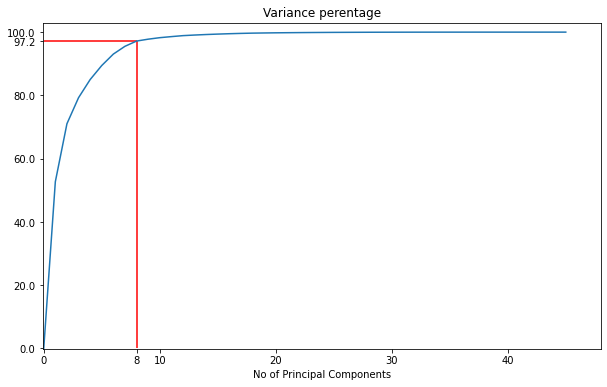

In [0]:
# The amount of variance explained by each of the selected components.
PCA_all_vecs = skt_all_pca_mod.explained_variance_ratio_
plot_pca_vecs = 8
pca_plot_arr = np.zeros(len(PCA_all_vecs) + 1)
pca_plot_arr[1:] = np.cumsum(PCA_all_vecs)
fig, ax = plt.subplots(1,1,figsize = (10,6))
p=plt.plot(pca_plot_arr*100)
plt.title('Variance perentage')
# plt.axvline(x=8,c='r')
plt.vlines(x=plot_pca_vecs, ymin=0, ymax=pca_plot_arr[8]*100,color = 'r')
plt.hlines(y = pca_plot_arr[plot_pca_vecs]*100,xmin=0, xmax=plot_pca_vecs, color = 'r' )
plt.xlim(-0.1,)
plt.ylim(-0.1,)

xt = ax.get_xticks() 
xt=np.append(xt,plot_pca_vecs)
ax.set_xticks(xt)

yt = ax.get_yticks() 
yt=np.append(yt,[pca_plot_arr[plot_pca_vecs]*100])
ax.set_yticks(yt)
# ax.set_yticklabels(100*pca_plot_arr[plot_pca_vecs])
plt.ylim([-0.1,103])
plt.xlim([-0.1,48])
plt.xlabel('No of Principal Components')
# plt.savefig('Figs/1_Var_vs_PC.png',dpi = 200)
plt.show()

In [0]:
# returns number of principal components until variance ratio is var_per (0.95)
var_per = 0.95
np.where(PCA_all_vecs.cumsum()>var_per)[0][0]

6

In [0]:
# Percentage of explained variance by first 8 PCs
pca_plot_arr[plot_pca_vecs]*100

97.17594774388319

In [0]:
# Selecting first 8 PC
n_pca_comp = 8
skt_pca_mod = PCA(n_components=n_pca_comp)
# skt_pca_mod = PCA()
start_time = pd.datetime.now()
X_PCA_train = skt_pca_mod.fit_transform(X=npX_train_norm, y=None)
print('duration: ', pd.datetime.now() - start_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


duration:  0:00:05.565008


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


In [0]:
print('Dims of PCA set are',str(X_PCA_train.shape))

Dims of PCA set are (1070994, 8)


In [0]:
# The amount of variance explained by each of the selected components.
PCA_vecs_skt = skt_pca_mod.explained_variance_
PCA_vecs_skt

array([23.72254606,  8.24597629,  3.70339908,  2.5789526 ,  1.99774111,
        1.62923907,  1.10447222,  0.74689088])

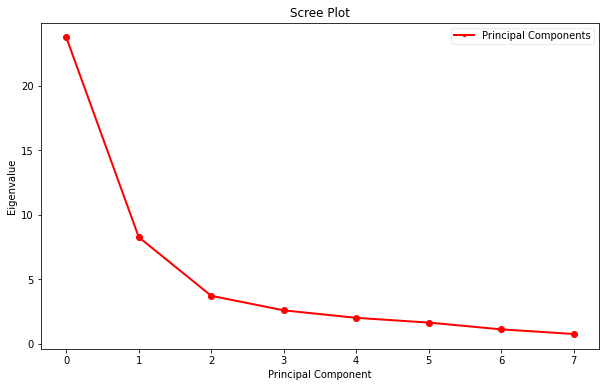

In [0]:
# plot the scree plot
fig = plt.figure(figsize=(10,6))
# sing_vals = np.arange(num_vars) + 1
plt.plot(np.arange(0,len(PCA_vecs_skt)), PCA_vecs_skt, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Principal Components'], loc='best', borderpad=0.3, 
                 shadow=False,
                 markerscale=0.4)
# plt.savefig('Figs/2_Scree_vs_PC.png',dpi = 200)
leg.get_frame().set_alpha(0.4)
plt.show()

### 4. Z scale the reduced variables (the PC’s)
#### this is the input for the autoencoder

In [0]:
X_pca_norm2 = preprocessing.scale(X_PCA_train)
# verify the normalizations
print('Normalized mean is: ',str(np.isclose(np.mean(X_pca_norm2,axis=0),0)-1))
print('Normalized std is: ',str(np.std(X_pca_norm2,axis=0)))

Normalized mean is:  [0 0 0 0 0 0 0 0]
Normalized std is:  [1. 1. 1. 1. 1. 1. 1. 1.]


### 5. **Score 1**: The fraud score is any function of these zscores that looks for extremes:

In [0]:
# aka take the lp-norm of each data point 
from scipy.linalg import norm
# 2 for euclidean, 1 for manhattan, np.inf for infty norm (max) etc
# p = np.inf 
# p = 1
p = 2
Scores_1 = norm(X_pca_norm2,ord = p,axis=1) # row-wise norm of X_pca_norm2

In [0]:
Scores_1.shape

(1070994,)

### 6.  **Score 2**: (a) train an autoencoder on all the data to reproduce the z scaled PC records, 




#### Autoencoder with Keras
Basic autoencoder configuration taken from here https://blog.keras.io/building-autoencoders-in-keras.html

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
# this is the size of our encoded representations
encoding_dim = 5 # number of hidden layer nodes

# this is our input placeholder
input_mat = Input(shape=(X_PCA_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_mat)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(X_PCA_train.shape[1], activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_mat, decoded)

Using TensorFlow backend.


In [0]:
# Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_mat, encoded)
# As well as the decoder model:

# create a placeholder for an encoded (5-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [0]:
# fit the model
no_of_epochs = 5
start_time = pd.datetime.now()
history = autoencoder.fit(x=X_PCA_train, y=X_PCA_train, batch_size = 1000, epochs = no_of_epochs, validation_split = 0)
print('duration: ', pd.datetime.now() - start_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
1070994/1070994 [==============================] - 2s 2us/step - loss: 5.4591
Epoch 2/5
1070994/1070994 [==============================] - 2s 2us/step - loss: 5.4177
Epoch 3/5
1070994/1070994 [==============================] - 2s 2us/step - loss: 5.4148
Epoch 4/5
1070994/1070994 [==============================] - 2s 2us/step - loss: 5.4138
Epoch 5/5
1070994/1070994 [==============================] - 2s 2us/step - loss: 5.4125
duration:  0:00:09.566768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


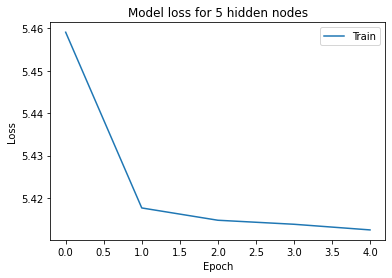

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss for '+str(encoding_dim)+' hidden nodes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend(['Train'], loc='upper right')
plt.show()

In [0]:
# get autoencoder output (decoder layer output)
start_time = pd.datetime.now()
encoded_out = encoder.predict(X_PCA_train)
decoded_out = decoder.predict(encoded_out)
print('duration: ', pd.datetime.now() - start_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


duration:  0:00:22.058768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


In [0]:
print('Output layer shape is:',str(decoded_out.shape))

Output layer shape is: (1070994, 8)


#### then 6.(b) the fraud score is any measure of difference between the original input record and the autoencoder output record

In [0]:
# define the difference between input-output:
auto_enc_diff = X_PCA_train - decoded_out # input- output

In [0]:
# 2 for euclidean, 1 for manhattan, np.inf for infty norm (max) etc
# p = np.inf 
# p = 1
# p = 2
Scores_2 = norm(auto_enc_diff,ord = p,axis=1) # row-wise norm of X_pca_norm2
print('Using '+str(p)+'-norm')

Using 2-norm


In [0]:
Scores_2.shape

(1070994,)

### 7. Final Score

In [0]:
saved_scores = pd.DataFrame({'Score 1': Scores_1, 'Score 2': Scores_2})
# saved_scores.to_csv('Scores/Scores_1_2.csv')
saved_scores.head()

,Score 1,Score 2
0,1.943138,2.274887
1,27.296351,66.760701
2,0.247036,0.323096
3,0.185182,0.369666
4,26.047672,48.387650


In [0]:
# res_df_prof = res_df_prof.transpose()
saved_scores['Avg'] = saved_scores.mean(axis = 1)
saved_scores['Score 1 Rank'] = saved_scores['Score 1'].rank(ascending = False)
saved_scores['Score 2 Rank'] = saved_scores['Score 2'].rank(ascending=False)
saved_scores['Average Rank'] = saved_scores[['Score 1 Rank','Score 2 Rank']].mean(axis = 1)
saved_scores['Max Rank'] = saved_scores[['Score 1 Rank','Score 2 Rank']].min(axis = 1)
saved_scores_ranked = saved_scores.sort_values(by='Average Rank',ascending=True)
# res_df_filter = res_df_filter.drop(columns='rank_avg')
saved_scores_ranked

,Score 1,Score 2,Avg,Score 1 Rank,Score 2 Rank,Average Rank,Max Rank
632815,1024.715260,2786.413832,1905.564546,1.0,2.0,1.5,1.0
565391,961.172318,3667.155105,2314.163711,3.0,1.0,2.0,1.0
917941,993.183736,2320.039527,1656.611632,2.0,3.0,2.5,2.0
1067359,781.715695,1762.724789,1272.220242,4.0,4.0,4.0,4.0
565397,642.981648,1514.781071,1078.881359,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...
1051063,0.021830,0.035135,0.028483,1070492.0,1070841.0,1070666.5,1070492.0
1039483,0.021785,0.034587,0.028186,1070498.0,1070870.0,1070684.0,1070498.0
1038615,0.021641,0.034634,0.028137,1070521.5,1070868.5,1070695.0,1070521.5
1038612,0.021641,0.034634,0.028137,1070521.5,1070868.5,1070695.0,1070521.5


# Outlier Records

In [0]:
# Finding the Top 10 Outliers in the dataset
no_max_outlier = 10
outl_index = saved_scores.nsmallest(n= no_max_outlier, columns='Average Rank').index

In [0]:
# outliers on the original dataset (transpose for readibility)
fraud_rec_df = or_mydata.loc[outl_index]
fraud_rec_df.transpose()

,632815,565391,917941,1067359,565397,585117,585438,248664,85885,556608
RECORD,632816,565392,917942,1067360,565398,585118,585439,248665,85886,556609
BBLE,4018420001,3085900700,4142600001,5078530085,3085910100,4004200001,4004590005,2056500001,1012540010,3083120001
B,4,3,4,5,3,4,4,2,1,3
BLOCK,1842,8590,14260,7853,8591,420,459,5650,1254,8312
LOT,1,700,1,85,100,1,5,1,10,1
EASEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNER,"864163 REALTY, LLC",U S GOVERNMENT OWNRD,"LOGAN PROPERTY, INC.",NaN,DEPT OF GENERAL SERVI,NEW YORK CITY ECONOMI,11-01 43RD AVENUE REA,PARKS AND RECREATION,PARKS AND RECREATION,PARKS AND RECREATION
BLDGCL,D9,V9,T1,B2,V9,O3,H9,Q1,Q1,Q1
TAXCLASS,2,4,4,1,4,4,4,4,4,4
LTFRONT,157,117,4910,1,466,298,94,600,4000,35


In [0]:
# The columns are the index numbers and the record numbers are just an addition of '1' to the index number
fraud_rec_df45 = data_45.loc[outl_index]
fraud_rec_df45.transpose()

,632815,565391,917941,1067359,565397,585117,585438,248664,85885,556608
FULLVAL/LOTAREA_ZIP,0.919499,1592.081273,7.246914,2558.571596,22.853828,0.246331,2.051023,1.576802,0.331849,408.335469
FULLVAL/LOTAREA_ZIP3,0.192541,1385.681932,5.447574,6270.033643,19.891030,0.131415,1.094198,0.578012,0.318177,314.526345
FULLVAL/LOTAREA_TAXCLASS,2.341124,1581.967175,3.519681,3632.454395,22.708643,0.132811,1.105825,0.365791,0.540708,359.079773
FULLVAL/LOTAREA_B,0.345402,1385.756760,1.339347,6270.033643,19.892104,0.050539,0.420800,0.578777,0.326518,314.543330
FULLVAL/BLDAREA_ZIP,3534.135490,4494.721035,993.429049,0.304738,2400.843894,1741.250855,1877.075905,2786.062612,1039.633226,47.329114
FULLVAL/BLDAREA_ZIP3,4257.238405,8314.381296,1026.532755,0.884768,4441.105780,3819.403005,4117.332856,1108.102807,1854.650036,38.323703
FULLVAL/BLDAREA_TAXCLASS,19500.092626,5452.544323,673.408900,0.730442,2912.462786,3471.839690,3742.658108,478.923115,1106.154854,25.132560
FULLVAL/BLDAREA_B,4219.121235,8315.201465,961.747459,0.884768,4441.543872,4958.403433,5345.180213,1075.559926,1907.666695,38.327484
FULLVAL/BLDVOL_ZIP,5460.541570,5967.278458,629.690458,0.333042,3187.406725,634.988791,1369.041291,1165.406597,1821.961530,83.758545
FULLVAL/BLDVOL_ZIP3,8145.805649,17046.180695,681.799477,0.822894,9105.174386,607.539073,1309.859464,365.547768,6989.309794,78.571423
